In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clootrack-assignment/Data Analyst - Test Data_new.xlsx


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
import re

In [3]:
!pip install langdetect
from langdetect import detect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=4735510a67c772a30e8c26bc38dc61ba643cbdbb2aa090a2b5bae46a1802d67f
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [4]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 1.5 MB/s eta 0:00:00


In [5]:
pd.options.mode.chained_assignment = None

In [6]:
df = pd.read_excel('../input/clootrack-assignment/Data Analyst - Test Data_new.xlsx')

In [7]:
df.head()

,Review,date,Location
0,I was very impressed with the resort.\n Great ...,2019-08-20,Sebastian
1,The rooms were nice the outside needs work als...,2019-08-20,Los Angeles
2,Great location! I have stayed at this hotel on...,2019-08-20,Georgia
3,The hotel was adequate for my stay. The strips...,2019-08-20,NaN
4,"Great location, room was large and spacious. P...",2019-08-19,Palm Harbor


# Cleaning Data

In [8]:
df['Review'].isnull().sum()

55

In [9]:
df = df.dropna(subset = ['Review'])

In [10]:
df['Review'].isnull().sum()

0

In [11]:
# As seen, there are multiple delimiters and texts that are unnecessary such as 'Read more'. We need to remove these

In [12]:
df['Review'] = df['Review'].replace('\n',"")
df['Review'] = df['Review'].str.replace('Read more',"")
df['Review'] = df['Review'].str.replace('Read less',"")

In [13]:
# We should also remove xml as well as many spaces from the text to make it cleaner

In [14]:
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) #xml removed

In [15]:
df['Review'] = df['Review'].apply(lambda x: re.sub(r'\s+', ' ', x))

In [16]:
df['Review'][0]

'I was very impressed with the resort Great staff at the main resort pool bar We had a blast with them Clean professional staff great location and very reasonable '

In [17]:
#Now the reviews look readable and neat. We must now clean the other unwanted column datas

# Working with Reviews

In [18]:
df = df.iloc[:,0:1]

In [19]:
df.head()

,Review
0,I was very impressed with the resort Great sta...
1,The rooms were nice the outside needs work als...
2,Great location I have stayed at this hotel on ...
3,The hotel was adequate for my stay The strips ...
4,Great location room was large and spacious Par...


In [20]:
df.isnull().sum()

Review    0
dtype: int64

## Converting all reviews to english 

In [21]:
for index, row in df['Review'].iteritems():
    try:
        lang = detect(row) #detecting each row
    except:
        lang='Unknown'
    df.loc[index, 'Languagereveiw'] = lang

In [22]:
df.shape

(6393, 2)

In [23]:
df = df[df.Languagereveiw!='Unknown'] #removing unkown languages

In [24]:
df.shape

(6390, 2)

In [25]:
from json import loads
from requests import get

In [26]:
# We will now use get request to translate the reviews to english and create new column, Review_en

In [27]:
for index, row in df['Review'].iteritems():
    try:
        src = df['Languagereveiw'][index]
        request_result = get("https://translate.googleapis.com/translate_a/single?client=gtx&dt=t&sl="+src+"&tl=en&q="+row)
        translated_text = loads(request_result.text)[0][0][0]
    except:
        translated_text = np.nan
    df.loc[index, 'Review_en'] = translated_text

In [28]:
df.head()

,Review,Languagereveiw,Review_en
0,I was very impressed with the resort Great sta...,en,I was very impressed with the resort Great sta...
1,The rooms were nice the outside needs work als...,en,The rooms were nice the outside needs work als...
2,Great location I have stayed at this hotel on ...,en,Great location I have stayed at this hotel on ...
3,The hotel was adequate for my stay The strips ...,en,The hotel was adequate for my stay The strips ...
4,Great location room was large and spacious Par...,en,Great location room was large and spacious Par...


In [29]:
# We now need to convert all the review to lower case for better analysis

In [30]:
df['Review_en'] = df['Review_en'].str.lower()

In [31]:
df.head()

,Review,Languagereveiw,Review_en
0,I was very impressed with the resort Great sta...,en,i was very impressed with the resort great sta...
1,The rooms were nice the outside needs work als...,en,the rooms were nice the outside needs work als...
2,Great location I have stayed at this hotel on ...,en,great location i have stayed at this hotel on ...
3,The hotel was adequate for my stay The strips ...,en,the hotel was adequate for my stay the strips ...
4,Great location room was large and spacious Par...,en,great location room was large and spacious par...


# Using NLP Algorithms to determine sentiment of text

## VADER APPROACH

In [32]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [33]:
senti = SentimentIntensityAnalyzer()

In [34]:
df['neg'] = df['Review_en'].apply(lambda x:senti.polarity_scores(x)['neg'])
df['neu'] = df['Review_en'].apply(lambda x:senti.polarity_scores(x)['neu'])
df['pos'] = df['Review_en'].apply(lambda x:senti.polarity_scores(x)['pos'])
df['comp'] = df['Review_en'].apply(lambda x:senti.polarity_scores(x)['compound'])

In [35]:
df.head()

,Review,Languagereveiw,Review_en,neg,neu,pos,comp
0,I was very impressed with the resort Great sta...,en,i was very impressed with the resort great sta...,0.000,0.617,0.383,0.9359
1,The rooms were nice the outside needs work als...,en,the rooms were nice the outside needs work als...,0.075,0.546,0.379,0.8360
2,Great location I have stayed at this hotel on ...,en,great location i have stayed at this hotel on ...,0.000,0.773,0.227,0.6249
3,The hotel was adequate for my stay The strips ...,en,the hotel was adequate for my stay the strips ...,0.077,0.817,0.107,0.3634
4,Great location room was large and spacious Par...,en,great location room was large and spacious par...,0.000,0.471,0.529,0.9260


In [36]:
def sentia(x):
    if x>=0.05:
        return 'pos'
    elif x<0.05 and x>-0.05:
        return 'neu'
    else:
        return 'neg'

In [37]:
df['Sentiment'] = df['comp'].apply(lambda x: sentia(x))

In [38]:
df.head()

,Review,Languagereveiw,Review_en,neg,neu,pos,comp,Sentiment
0,I was very impressed with the resort Great sta...,en,i was very impressed with the resort great sta...,0.000,0.617,0.383,0.9359,pos
1,The rooms were nice the outside needs work als...,en,the rooms were nice the outside needs work als...,0.075,0.546,0.379,0.8360,pos
2,Great location I have stayed at this hotel on ...,en,great location i have stayed at this hotel on ...,0.000,0.773,0.227,0.6249,pos
3,The hotel was adequate for my stay The strips ...,en,the hotel was adequate for my stay the strips ...,0.077,0.817,0.107,0.3634,pos
4,Great location room was large and spacious Par...,en,great location room was large and spacious par...,0.000,0.471,0.529,0.9260,pos


## Insight 1: Number of positive, neutral and negative reviews

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

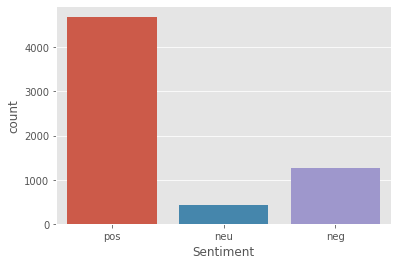

In [39]:
sns.countplot(x='Sentiment',data=df)

## Insight 2: Hotel words used in reviews

In [40]:
!pip install spacy

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.4 requires wrapt~=1.12.1, but you have wrapt 1.14.1 which is incompatible.
tensorflow-transform 1.8.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
te

In [41]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [42]:
words_described = []
for row in df['Review_en']:
    dic = nlp(row)
    target = ''
    for token in dic:
        if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
            target = token.text
    words_described.append(target)
    


In [43]:
df['described_place'] = words_described
df.head()

,Review,Languagereveiw,Review_en,neg,neu,pos,comp,Sentiment,described_place
0,I was very impressed with the resort Great sta...,en,i was very impressed with the resort great sta...,0.000,0.617,0.383,0.9359,pos,
1,The rooms were nice the outside needs work als...,en,the rooms were nice the outside needs work als...,0.075,0.546,0.379,0.8360,pos,outside
2,Great location I have stayed at this hotel on ...,en,great location i have stayed at this hotel on ...,0.000,0.773,0.227,0.6249,pos,
3,The hotel was adequate for my stay The strips ...,en,the hotel was adequate for my stay the strips ...,0.077,0.817,0.107,0.3634,pos,breakfast
4,Great location room was large and spacious Par...,en,great location room was large and spacious par...,0.000,0.471,0.529,0.9260,pos,parking


In [44]:
df['described_place'] = df['described_place'].replace('beds','bed')
df['described_place'] = df['described_place'].replace('rooms','room')

In [45]:
df['described_place'].value_counts().head(10)

            1850
room         633
staff        415
hotel        368
location     241
bed          100
service       80
property      74
bathroom      62
stay          61
Name: described_place, dtype: int64

In [46]:
df.head()

,Review,Languagereveiw,Review_en,neg,neu,pos,comp,Sentiment,described_place
0,I was very impressed with the resort Great sta...,en,i was very impressed with the resort great sta...,0.000,0.617,0.383,0.9359,pos,
1,The rooms were nice the outside needs work als...,en,the rooms were nice the outside needs work als...,0.075,0.546,0.379,0.8360,pos,outside
2,Great location I have stayed at this hotel on ...,en,great location i have stayed at this hotel on ...,0.000,0.773,0.227,0.6249,pos,
3,The hotel was adequate for my stay The strips ...,en,the hotel was adequate for my stay the strips ...,0.077,0.817,0.107,0.3634,pos,breakfast
4,Great location room was large and spacious Par...,en,great location room was large and spacious par...,0.000,0.471,0.529,0.9260,pos,parking


In [47]:
new_df = df[(df['described_place'] == 'room') | (df['described_place'] == 'staff') | (df['described_place'] == 'hotel') | (df['described_place'] == 'location') | (df['described_place'] == 'bed')][['Sentiment','described_place']]

In [48]:
new_df

,Sentiment,described_place
9,pos,room
12,pos,room
16,pos,bed
19,pos,room
27,pos,staff
...,...,...
6439,pos,room
6440,pos,bed
6445,pos,bed
6446,neu,staff


<AxesSubplot:xlabel='described_place', ylabel='count'>

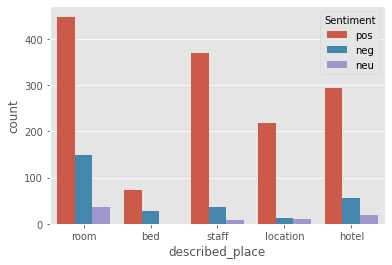

In [49]:
sns.countplot(x='described_place',data=new_df, hue='Sentiment')

## Insight 3: Finding the countries and Insight 4: Finding Country wise reviews

In [50]:
df_loc = pd.read_excel('../input/clootrack-assignment/Data Analyst - Test Data_new.xlsx')

In [51]:
df_loc

,Review,date,Location
0,I was very impressed with the resort.\n Great ...,2019-08-20,Sebastian
1,The rooms were nice the outside needs work als...,2019-08-20,Los Angeles
2,Great location! I have stayed at this hotel on...,2019-08-20,Georgia
3,The hotel was adequate for my stay. The strips...,2019-08-20,NaN
4,"Great location, room was large and spacious. P...",2019-08-19,Palm Harbor
...,...,...,...
6443,"·the staff were all so friendly. frank, the ch...",2019-07-12,United States of America
6444,·the internet barely worked or didn't work,2019-07-12,United States of America
6445,·the location was great.\n \n \n \n \n ·the be...,2019-07-10,United States of America
6446,·we were early for check in and the staff was ...,2019-07-10,United States of America


In [52]:
df_loc = df_loc.iloc[:,2:3]

In [53]:
df_loc

,Location
0,Sebastian
1,Los Angeles
2,Georgia
3,NaN
4,Palm Harbor
...,...
6443,United States of America
6444,United States of America
6445,United States of America
6446,United States of America


In [54]:
!pip install geopy

In [55]:
from geopy.geocoders import Nominatim

In [56]:
geolocator = Nominatim(user_agent="http12",timeout=10)

In [57]:
location = geolocator.geocode('San Jose ca')
country = str(location).split(',')[-1].strip()
country
#We will use the above logic to get the country of every location.

'United States'

In [58]:
#First we need to clean data

In [59]:
df_loc.isnull().sum()

Location    4737
dtype: int64

In [60]:
df_loc = df_loc.dropna()

In [61]:
df_loc.isnull().sum()

Location    0
dtype: int64

In [62]:
df_loc.shape
import time
df_loc['Location'][1125]

'San Jose ca'

In [63]:
countries = []
for loc in df_loc['Location'].iteritems():
    location = geolocator.geocode(loc)
    country = str(location).split(',')[-1].strip()
    countries.append(country)
    
    
    

In [64]:
df_loc['Country']=countries

In [65]:
df_loc.head()

,Location,Country
0,Sebastian,España
1,Los Angeles,Uruguay
2,Georgia,United States
4,Palm Harbor,United States
10,California,United States


In [66]:
df_loc['Country'].value_counts().head(10)

United States              1110
Canada                      119
United Kingdom               69
Pilipinas / Philippines      60
Argentina                    56
None                         46
México                       34
Chile                        28
Deutschland                  17
Nederland                    16
Name: Country, dtype: int64

In [67]:
new_df1 = df_loc[(df_loc['Country']=='United States') | (df_loc['Country']=='Canada') | (df_loc['Country']=='United Kingdom') | (df_loc['Country']=='Pilipinas / Philippines') | (df_loc['Country']=='Argentina')][['Country']]

In [68]:
new_df1

,Country
2,United States
4,United States
10,United States
15,United States
24,Argentina
...,...
6443,United States
6444,United States
6445,United States
6446,United States


[Text(0, 0, 'United States'),
 Text(1, 0, 'Argentina'),
 Text(2, 0, 'Canada'),
 Text(3, 0, 'United Kingdom'),
 Text(4, 0, 'Pilipinas / Philippines')]

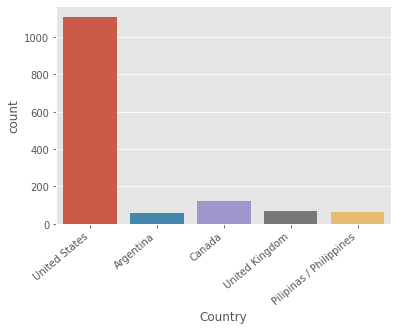

In [69]:
ax1 = sns.countplot(x='Country',data=new_df1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")

In [70]:
df3 = df_loc.join(df)
df3

,Location,Country,Review,Languagereveiw,Review_en,neg,neu,pos,comp,Sentiment,described_place
0,Sebastian,España,I was very impressed with the resort Great sta...,en,i was very impressed with the resort great sta...,0.000,0.617,0.383,0.9359,pos,
1,Los Angeles,Uruguay,The rooms were nice the outside needs work als...,en,the rooms were nice the outside needs work als...,0.075,0.546,0.379,0.8360,pos,outside
2,Georgia,United States,Great location I have stayed at this hotel on ...,en,great location i have stayed at this hotel on ...,0.000,0.773,0.227,0.6249,pos,
4,Palm Harbor,United States,Great location room was large and spacious Par...,en,great location room was large and spacious par...,0.000,0.471,0.529,0.9260,pos,parking
10,California,United States,Very clean and friendly and I love the locatio...,en,very clean and friendly and i love the locatio...,0.000,0.687,0.313,0.8940,pos,
...,...,...,...,...,...,...,...,...,...,...,...
6443,United States of America,United States,the staff were all so friendly frank the chef ...,en,the staff were all so friendly frank the chef ...,0.000,0.828,0.172,0.9716,pos,pool
6444,United States of America,United States,the internet barely worked or didnt work,en,the internet barely worked or didnt work,0.000,1.000,0.000,0.0000,neu,internet
6445,United States of America,United States,the location was great the bed was the most un...,en,the location was great the bed was the most un...,0.145,0.650,0.205,0.2975,pos,bed
6446,United States of America,United States,we were early for check in and the staff was v...,en,we were early for check in and the staff was v...,0.000,1.000,0.000,0.0000,neu,staff


In [71]:
new_df2 =  df3[(df3['Country']=='United States') | (df3['Country']=='Canada') | (df3['Country']=='United Kingdom') | (df3['Country']=='Pilipinas / Philippines') | (df3['Country']=='Argentina')][['Country','Sentiment']]

In [72]:
new_df2

,Country,Sentiment
2,United States,pos
4,United States,pos
10,United States,pos
15,United States,pos
24,Argentina,neg
...,...,...
6443,United States,pos
6444,United States,neu
6445,United States,pos
6446,United States,neu


[Text(0, 0, 'United States'),
 Text(1, 0, 'Argentina'),
 Text(2, 0, 'Canada'),
 Text(3, 0, 'United Kingdom'),
 Text(4, 0, 'Pilipinas / Philippines')]

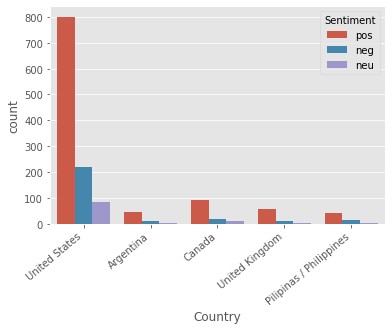

In [73]:
ax = sns.countplot(x='Country',data=new_df2,hue = 'Sentiment')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

## Insight 5: Regarding dates of reviews - Seen in excel Sheet

In [74]:
df3.to_excel('./Data Analyst - Test Data_new.xlsx',sheet_name = 'Final')